In [1]:
from src.geojson import build_geojson_feature_collection
from src.cluster_stats import Stats
from src.render import plot_clusters
from src.geojson import build_geojson_feature_collection
import logging
from run import cluster
import polars as pl


In [2]:
# Inputs
input_file = "data/data-nh-vt.csv"
geohash_precision = 5
show_dendrogram = True
log_file = "run.log"
output_file = "output.geojson"
num_clusters = 6
use_cache = False
plot = True

In [3]:
# set up logging
logging.basicConfig(filename=log_file, encoding="utf-8", level=logging.INFO)


In [4]:
from src.lazyframes.darwin_core_csv import DarwinCoreCsvLazyFrame

darwin_core_csv_lazy_frame = DarwinCoreCsvLazyFrame.from_file(input_file)

In [5]:
from src.dataframes.taxonomy import TaxonomyDataFrame

taxonomy_dataframe = TaxonomyDataFrame.build(darwin_core_csv_lazy_frame)

In [6]:
from src.dataframes.geohash_species_counts import GeohashSpeciesCountsDataFrame

geohash_taxa_counts_dataframe = GeohashSpeciesCountsDataFrame.build(
    darwin_core_csv_lazy_frame, geohash_precision
)

In [7]:
geohash_taxa_counts_dataframe.df

geohash,kingdom,rank,name,count
str,enum,enum,str,u32
"""dregh""","""Animalia""","""species""","""Mniotilta varia""",1
"""dregh""","""Animalia""","""species""","""Setophaga caerulescens""",3
"""dregh""","""Animalia""","""species""","""Cardinalis cardinalis""",1
"""dregh""","""Animalia""","""species""","""Sphyrapicus varius""",2
"""dregh""","""Plantae""","""species""","""Rubus idaeus""",1
…,…,…,…,…
"""f2j3w""","""Animalia""","""species""","""Polygonia progne""",1
"""f2j3w""","""Animalia""","""species""","""Leiothlypis ruficapilla""",6
"""f2j3w""","""Animalia""","""species""","""Melospiza georgiana""",3


/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/sklearn/decomposition/_incremental_pca.py:376: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


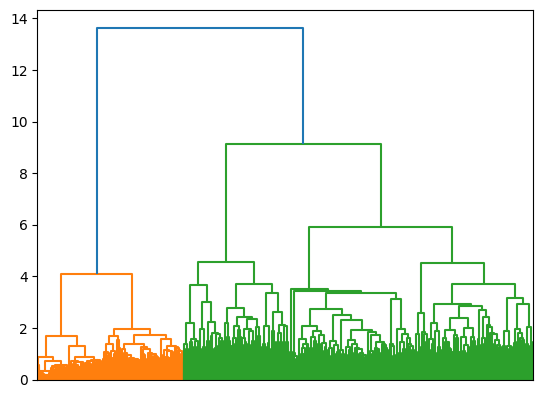

In [8]:

cluster_index = cluster.run(
    geohash_taxa_counts_dataframe,
    num_clusters,
    show_dendrogram,
    use_cache,
)

In [9]:
# Exclude the Aleutian Islands
# cluster_index.df = cluster_index.df.filter(pl.col("geohash").str.starts_with("z").not_())

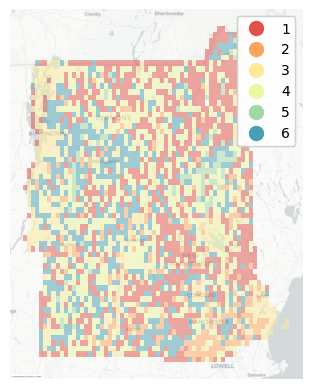

In [10]:
from src.dataframes.cluster_color import ClusterColorDataFrame

# Find the top averages of taxon
all_stats = Stats.build(geohash_taxa_counts_dataframe)

cluster_colors = ClusterColorDataFrame.from_clusters(cluster_index.cluster_ids())

feature_collection = build_geojson_feature_collection(
    cluster_index,
    cluster_colors,
)

# print_results(darwin_core_aggregations, all_stats, cluster_dataframe)

from run import write_geojson
write_geojson(feature_collection, output_file)

plot_clusters(feature_collection)

# write_geojson(feature_collection, args.output_file)

In [11]:
from src.html_output import build_html_output
from IPython.display import display, HTML

html = build_html_output(
    geohash_taxa_counts_dataframe,
    cluster_index,
    cluster_colors,
    all_stats,
)

display(HTML(html))


In [12]:
from scipy.spatial import distance
from src.cluster import build_condensed_distance_matrix
from sklearn.manifold import TSNE

condensed_distance_matrix = build_condensed_distance_matrix(
    geohash_taxa_counts_dataframe,
    use_cache,
)

clusters = cluster_index.df.sort(by=pl.col("geohash"))["cluster"]

square_distance_matrix = distance.squareform(condensed_distance_matrix)

tsne = TSNE(
    n_components=2,
    random_state=42,
    metric="precomputed",
    init="random",
)
X_tsne = tsne.fit_transform(square_distance_matrix)
tsne.kl_divergence_


/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/sklearn/decomposition/_incremental_pca.py:376: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2.0060346126556396

In [20]:
import seaborn as sns

sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=cluster_index.df["cluster"],
    palette=cluster_colors.to_dict(),
    alpha=1,
)

AttributeError: 'ClusterColorDataFrame' object has no attribute 'to_dict'

In [17]:
notable_species = set()

for (cluster, geohashes) in cluster_index.iter_clusters_and_geohashes():
    stats = Stats.build(
        geohash_taxa_counts_dataframe,
        geohash_filter=geohashes,
    )
    for kingdom, species, count in (
        stats.taxon.sort(by="count", descending=True)
        .limit(10)
        .select(["kingdom", "species", "count"])
        .collect()
        .iter_rows(named=False)
    ):
        average = (
            stats.taxon.filter(
                pl.col("kingdom") == kingdom, pl.col("species") == species
            )
            .collect()
            .get_column("average")
            .item()
        )
        all_average = (
            all_stats.taxon.filter(
                pl.col("kingdom") == kingdom, pl.col("species") == species
            )
            .collect()
            .get_column("average")
            .item()
        )

        # If the difference between the average of the cluster and the average of all is greater than 50%, then it is notable
        percent_diff = (average / all_average * 100) - 100
        if abs(percent_diff) > 50:
            notable_species.add(species)

notable_species

{'Catharus bicknelli',
 'Catharus ustulatus',
 'Junco hyemalis',
 'Setophaga coronata',
 'Setophaga striata',
 'Setophaga virens',
 'Troglodytes hiemalis',
 'Zenaida macroura',
 'Zonotrichia albicollis'}

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
from scipy.cluster.hierarchy import linkage

linkage_array = linkage(condensed_distance_matrix, "ward")

ordered_geohashes = geohash_taxa_counts_dataframe.ordered_geohashes()

def min_max_normalize(series: pl.Series) -> pl.Series:
    return (series - series.min()) / (series.max() - series.min())

col_colors = []
for geohash in ordered_geohashes:
    cluster = cluster_index.cluster_for_geohash(geohash)
    col_colors.append(cluster_colors.get_color_for_cluster(cluster))

data = {}
for species in sorted(notable_species):
    counts = []

    for geohash in ordered_geohashes:
        geohash_counts_species = geohash_taxa_counts_dataframe.df.filter(
            pl.col("geohash") == geohash, pl.col("name") == species
        ).get_column("count").sum()
        geohash_counts_all = geohash_taxa_counts_dataframe.df.filter(
            pl.col("geohash") == geohash
        ).get_column("count").sum()
        geohash_average = geohash_counts_species / geohash_counts_all
        all_average = (
            all_stats.taxon.filter(
                # TODO: Add kingdom in filter
                pl.col("species") == species
            )
            .collect()
            .get_column("average")
            .item()
        )
        counts.append(geohash_average - all_average)
    counts = pl.Series(
        values=counts,
        name=species,
    )
    # counts = counts / counts.max()
    # counts = counts.pow(1 / 3)
    data[species] = min_max_normalize(counts)


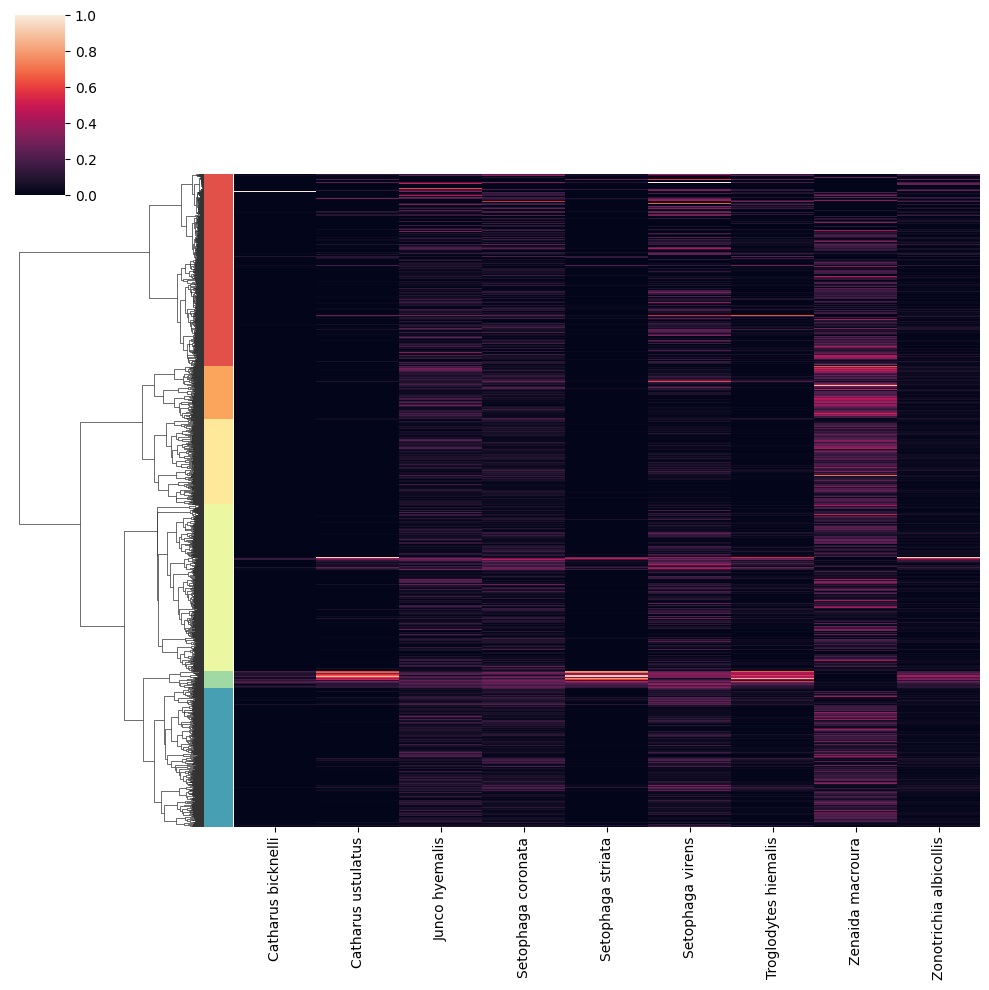

In [19]:
dataframe = pl.DataFrame(data=data)
sns.clustermap(
    data=dataframe,
    col_cluster=False,
    row_cluster=True,
    row_linkage=linkage_array,
    row_colors=col_colors,
    xticklabels=dataframe.columns,
    yticklabels=False,
)